# E-commerce Customer Segmentation and Prediction

In [5]:
#importing required libraries

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score

Data Acquisition

In [28]:
# importing dataset
Dataset = pd.read_csv(r"C:\Users\aloks\Downloads\data.csv", encoding='latin1')

In [29]:
# Creating copy of original dataset
df = Dataset.copy()

Data Understanding

In [30]:
# Displaying first five rows of the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [31]:
# Getting information about the dataset
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [32]:
# Checking for missing values
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Data Cleaning and Preprocessing

In [35]:
# Fill Description missing with "Unknown"
df['Description'] = df['Description'].fillna(df['Description'].mode()[0])

# Drop missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Reset index after dropping rows
df.reset_index(drop=True, inplace=True)

In [36]:
# Count duplicate rows
duplicates = df.duplicated().sum()
print("Total duplicate rows:", duplicates)

Total duplicate rows: 5225


In [37]:
# Remove duplicate rows
df.drop_duplicates(inplace=True)

In [38]:
# Removing negative quantity
df = df[df['Quantity'] > 0]

In [39]:
# Convert columns to appropriate data types
df['InvoiceNo'] = df['InvoiceNo'].astype(int)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'], format='mixed')
df['CustomerID'] = df['CustomerID'].astype(int)

In [40]:
# Create a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

RFM Method

In [41]:
# Set a 'snapshot_date' to calculate recency. This will be one day after the last transaction in the dataset.
snapshot_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

# Group by CustomerID and calculate RFM values
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda date: (snapshot_date - date.max()).days, # Recency: Days since last purchase
    'InvoiceNo': 'nunique',                                         # Frequency: Count of unique invoices
    'TotalPrice': 'sum'                                             # Monetary: Sum of all purchases
})

# Rename the columns for clarity
rfm.rename(columns={'InvoiceDate': 'Recency',
                    'InvoiceNo': 'Frequency',
                    'TotalPrice': 'MonetaryValue'}, inplace=True)

print("\nRFM DataFrame created successfully! Here are the first 5 rows:")
print(rfm.head())


RFM DataFrame created successfully! Here are the first 5 rows:
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        4310.00
12348            75          4        1797.24
12349            19          1        1757.55
12350           310          1         334.40


EDA for RFM

Plotting RFM Distributions...


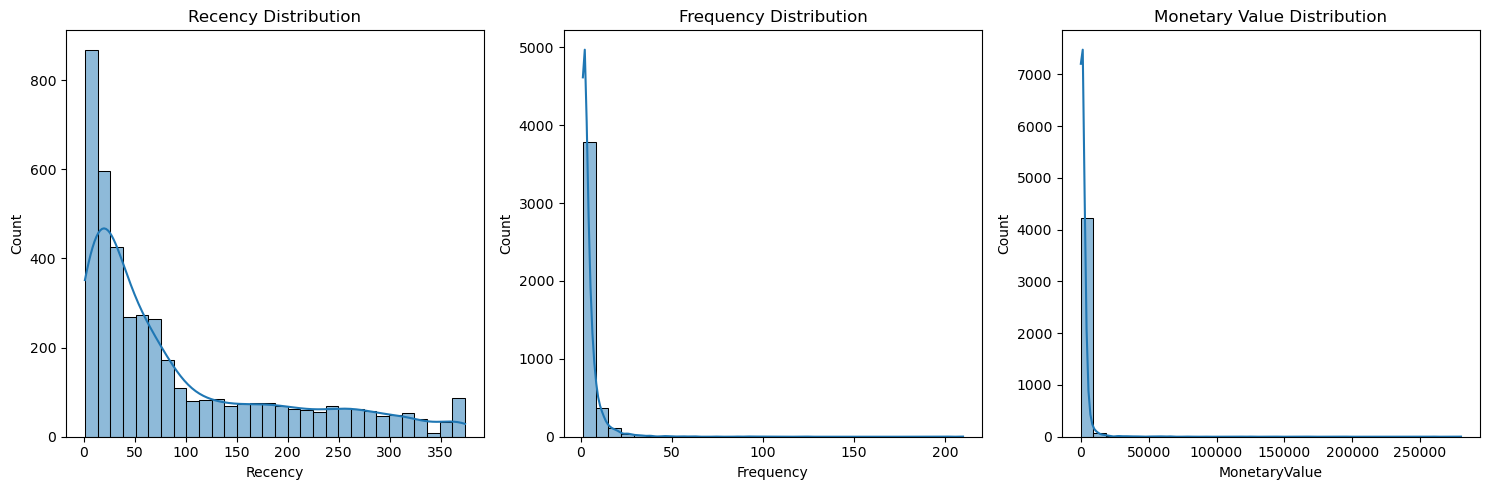

In [42]:
# --- Plotting RFM Distributions ---
print("Plotting RFM Distributions...")
plt.figure(figsize=(15, 5))

# Plot Recency distribution
plt.subplot(1, 3, 1)
sns.histplot(rfm['Recency'], kde=True, bins=30)
plt.title('Recency Distribution')

# Plot Frequency distribution
plt.subplot(1, 3, 2)
sns.histplot(rfm['Frequency'], kde=True, bins=30)
plt.title('Frequency Distribution')

# Plot MonetaryValue distribution
plt.subplot(1, 3, 3)
sns.histplot(rfm['MonetaryValue'], kde=True, bins=30)
plt.title('Monetary Value Distribution')

plt.tight_layout()
plt.show()


Plotting relationships between RFM variables...


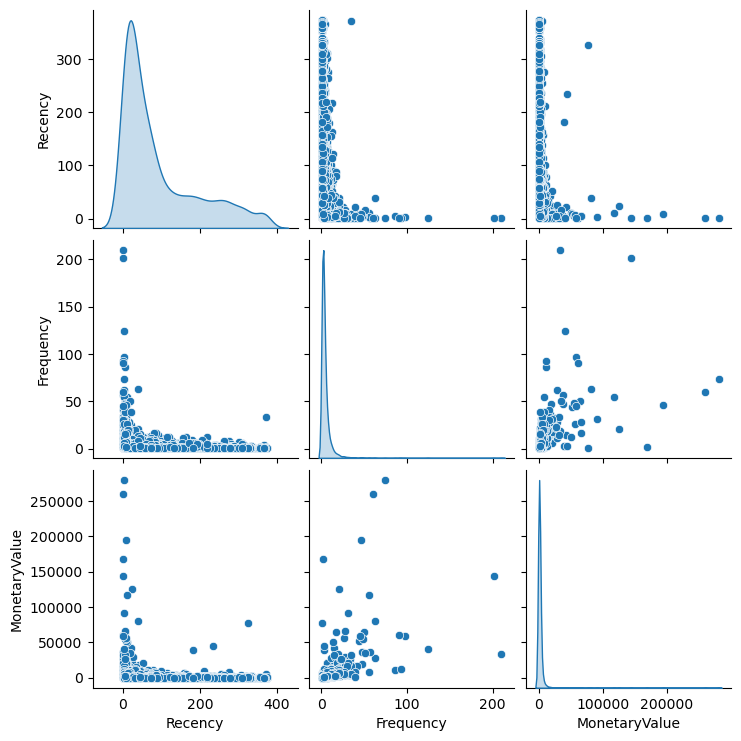

In [43]:
# --- Exploring Relationships between RFM variables ---
print("\nPlotting relationships between RFM variables...")
sns.pairplot(rfm, diag_kind='kde')
plt.show()


Correlation between RFM variables:


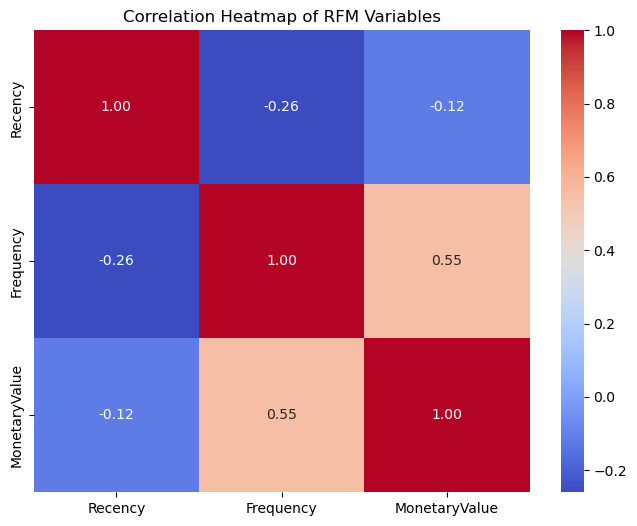

In [44]:
# --- Correlation Heatmap ---
print("\nCorrelation between RFM variables:")
correlation_matrix = rfm.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of RFM Variables')
plt.show()

In [45]:
# Address Skewness with Log Transformation

# Apply log transformation + 1 to each column(since the log of 0 is undefined)
rfm_log = rfm.apply(lambda x: np.log(x + 1))

print("RFM data has been log-transformed. Here's the first 5 rows:")
print(rfm_log.head())

RFM data has been log-transformed. Here's the first 5 rows:
             Recency  Frequency  MonetaryValue
CustomerID                                    
12346       5.789960   0.693147      11.253955
12347       1.098612   2.079442       8.368925
12348       4.330733   1.609438       7.494564
12349       2.995732   0.693147       7.472245
12350       5.739793   0.693147       5.815324


In [46]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the log-transformed data
rfm_scaled = scaler.fit_transform(rfm_log)

# The result is a NumPy array, so let's convert it back to a DataFrame for easier viewing
rfm_scaled = pd.DataFrame(rfm_scaled, index=rfm.index, columns=rfm.columns)

print("Scaled RFM data is ready. Here are the first 5 rows:")
print(rfm_scaled.head())

Scaled RFM data is ready. Here are the first 5 rows:
             Recency  Frequency  MonetaryValue
CustomerID                                    
12346       1.462236  -0.955013       3.697687
12347      -2.038611   1.074523       1.411820
12348       0.373310   0.386437       0.719046
12349      -0.622914  -0.955013       0.701362
12350       1.424800  -0.955013      -0.611449


Clustering

1. K Means Clustering

Elbow plot has been generated and saved as 'elbow_plot.png'


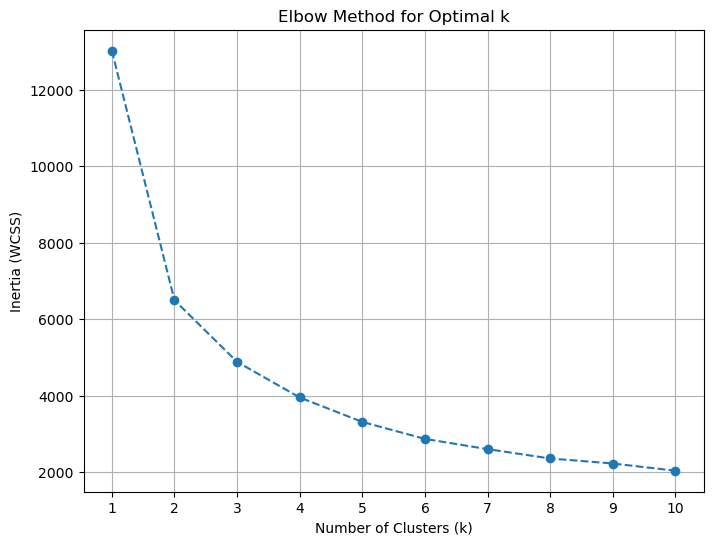

In [47]:
# Create an empty list to store the inertia values
inertia = []

# Loop through a range of k values
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

# Plot the inertia values
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)

# Save the plot
plt.savefig('elbow_plot.png')
print("Elbow plot has been generated and saved as 'elbow_plot.png'")
plt.show()

In [48]:
# Choose the optimal k from the elbow plot
optimal_k = 4 

# Apply K-Means with the optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(rfm_scaled)

# Add the cluster labels back to the original rfm DataFrame
rfm['KMeans_Cluster'] = clusters

print(f"\nSuccessfully created {optimal_k} clusters!")
print("Here are the first 5 rows of the rfm DataFrame with the new 'Cluster' column:")
print(rfm.head())


Successfully created 4 clusters!
Here are the first 5 rows of the rfm DataFrame with the new 'Cluster' column:
            Recency  Frequency  MonetaryValue  KMeans_Cluster
CustomerID                                                   
12346           326          1       77183.60               2
12347             2          7        4310.00               1
12348            75          4        1797.24               2
12349            19          1        1757.55               0
12350           310          1         334.40               3


2. Hierarchical Clustering

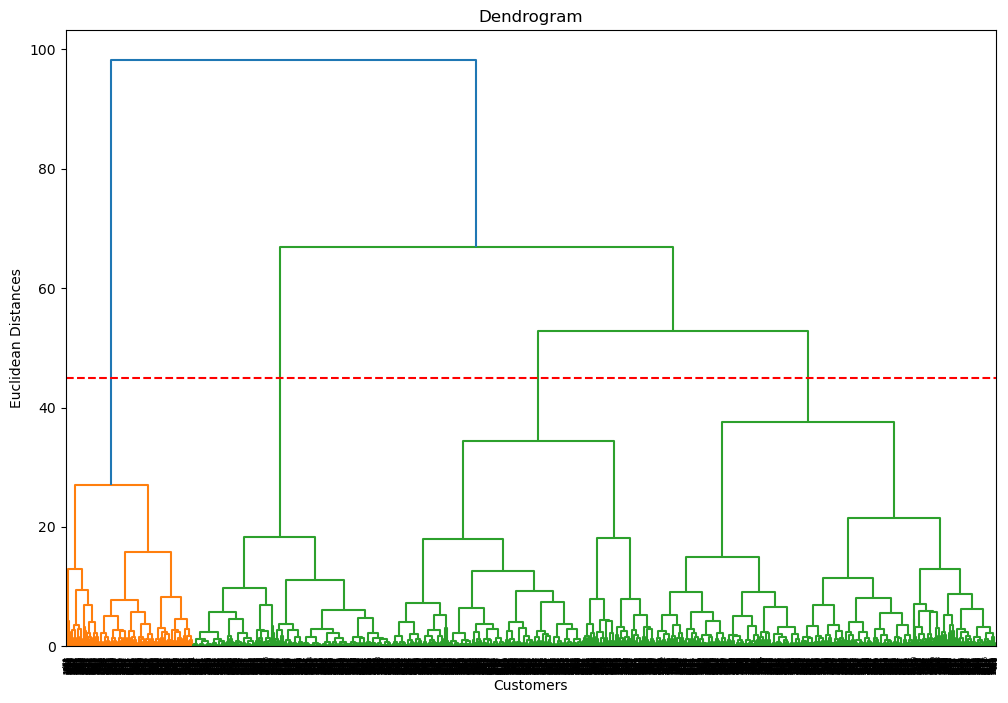

In [50]:
# Plot the Dendrogram to find the optimal number of clusters
plt.figure(figsize=(12, 8))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=45, color='r', linestyle='--') # Draw a line to 'cut' the tree
plt.show()

In [51]:
# Apply Hierarchical Clustering
# Based on the dendrogram, we can see 4 clusters is a good choice
hc = AgglomerativeClustering(n_clusters=4,  linkage='ward')
hc_clusters = hc.fit_predict(rfm_scaled)

# Add these cluster labels to a new column for comparison
rfm['HC_Cluster'] = hc_clusters

print("Hierarchical Clustering complete. 'HC_Cluster' column added.")
print(rfm.head())

Hierarchical Clustering complete. 'HC_Cluster' column added.
            Recency  Frequency  MonetaryValue  KMeans_Cluster  HC_Cluster
CustomerID                                                               
12346           326          1       77183.60               2           0
12347             2          7        4310.00               1           3
12348            75          4        1797.24               2           0
12349            19          1        1757.55               0           0
12350           310          1         334.40               3           2


3. Density Based Clustering

In [52]:
# Apply DBSCAN
# Finding the right 'eps' and 'min_samples' can require some experimentation
dbscan = DBSCAN(eps=0.5, min_samples=5) # These are starting values; you may need to tune them
db_clusters = dbscan.fit_predict(rfm_scaled)

# Add these cluster labels to another new column
# Note: The '-1' label indicates an outlier identified by DBSCAN
rfm['DB_Cluster'] = db_clusters

print("\nDBSCAN Clustering complete. 'DB_Cluster' column added.")
print("Number of clusters found:", len(set(db_clusters)) - (1 if -1 in db_clusters else 0))
print("Number of outliers found:", list(db_clusters).count(-1))
print(rfm.head())


DBSCAN Clustering complete. 'DB_Cluster' column added.
Number of clusters found: 2
Number of outliers found: 63
            Recency  Frequency  MonetaryValue  KMeans_Cluster  HC_Cluster  \
CustomerID                                                                  
12346           326          1       77183.60               2           0   
12347             2          7        4310.00               1           3   
12348            75          4        1797.24               2           0   
12349            19          1        1757.55               0           0   
12350           310          1         334.40               3           2   

            DB_Cluster  
CustomerID              
12346               -1  
12347                0  
12348                0  
12349                1  
12350                1  


Selecting best Clustering Model by comparing using Silhouette Scores

In [53]:
# Create a dictionary to store the Silhouette Scores
scores = {}

In [54]:
# For K-Means Score
kmeans_score = silhouette_score(rfm_scaled, rfm['KMeans_Cluster'])
scores['K-Means'] = kmeans_score
print(f"Silhouette Score for K-Means: {kmeans_score:.4f}")

Silhouette Score for K-Means: 0.3357


In [55]:
# For Hierarchical Clustering Score
hc_score = silhouette_score(rfm_scaled, rfm['HC_Cluster'])
scores['Hierarchical'] = hc_score
print(f"Silhouette Score for Hierarchical Clustering: {hc_score:.4f}")

Silhouette Score for Hierarchical Clustering: 0.2753


In [56]:
# For DBSCAN Score
# Note: We must filter out outliers (label -1) for a meaningful score
db_filtered_data = rfm_scaled[rfm['DB_Cluster'] != -1]
db_filtered_labels = rfm['DB_Cluster'][rfm['DB_Cluster'] != -1]
# Only calculate score if more than one cluster was found
if len(set(db_filtered_labels)) > 1:
    db_score = silhouette_score(db_filtered_data, db_filtered_labels)
    scores['DBSCAN'] = db_score
    print(f"Silhouette Score for DBSCAN (excluding outliers): {db_score:.4f}")
else:
    print("DBSCAN found only one cluster or no clusters, Silhouette Score cannot be calculated.")
    scores['DBSCAN'] = 0.0

Silhouette Score for DBSCAN (excluding outliers): 0.2930


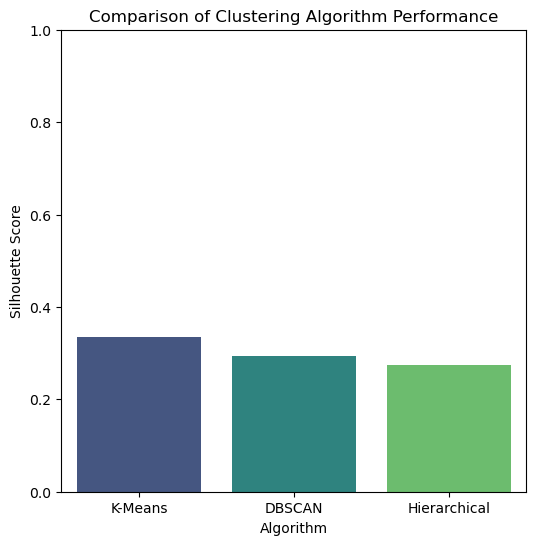

In [57]:
# --- Plot the Comparison Graph ---
scores_df = pd.DataFrame(list(scores.items()), columns=['Algorithm', 'Silhouette Score']).sort_values(by='Silhouette Score', ascending=False)

plt.figure(figsize=(6, 6))
sns.barplot(x='Algorithm', y='Silhouette Score', data=scores_df, palette='viridis')
plt.title('Comparison of Clustering Algorithm Performance')
plt.ylim(0, 1) # Score is between -1 and 1, but usually positive in practice
plt.show()

In [58]:
# Choose K Means Clustering
rfm['Cluster'] = rfm['KMeans_Cluster']
rfm.drop(['KMeans_Cluster', 'HC_Cluster', 'DB_Cluster'], axis=1, inplace=True)

In [59]:
rfm.head()

,Recency,Frequency,MonetaryValue,Cluster
CustomerID,,,,
12346,326,1,77183.60,2
12347,2,7,4310.00,1
12348,75,4,1797.24,2
12349,19,1,1757.55,0
12350,310,1,334.40,3


Model Building

In [60]:
# Define features (X) and target (y) variables
# We use the original RFM values for better interpretability
X = rfm[['Recency', 'Frequency', 'MonetaryValue']]
y = rfm['Cluster']

print("Features (X) and Target (y) are defined.")
print("\nFirst 5 rows of Features (X):")
print(X.head())
print("\nFirst 5 rows of Target (y):")
print(y.head())

Features (X) and Target (y) are defined.

First 5 rows of Features (X):
            Recency  Frequency  MonetaryValue
CustomerID                                   
12346           326          1       77183.60
12347             2          7        4310.00
12348            75          4        1797.24
12349            19          1        1757.55
12350           310          1         334.40

First 5 rows of Target (y):
CustomerID
12346    2
12347    1
12348    2
12349    0
12350    3
Name: Cluster, dtype: int32


In [61]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split successfully:")
print(f"Training set has {X_train.shape[0]} samples.")
print(f"Testing set has {X_test.shape[0]} samples.")

Data split successfully:
Training set has 3471 samples.
Testing set has 868 samples.


1. Logistic Regression

In [62]:
# Initialize the model (max_iter is increased to ensure convergence)
log_reg = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
log_reg.fit(X_train, y_train)

# Make predictions
y_pred_lr = log_reg.predict(X_test)
# y_prob_lr = log_reg.predict_proba(X_test)[:, 1] # Probabilities for ROC curve

Accuracy: 0.9378

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       144
           1       0.89      0.96      0.93       162
           2       0.93      0.89      0.91       247
           3       0.98      0.97      0.98       315

    accuracy                           0.94       868
   macro avg       0.93      0.94      0.93       868
weighted avg       0.94      0.94      0.94       868

Confusion Matrix:


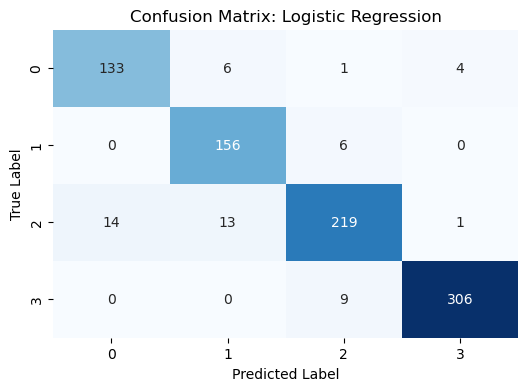

In [63]:
# Evaluate and print metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Confusion Matrix
print("Confusion Matrix:")
cm_lr = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Logistic Regression')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


2. Decision Tree Classifier

In [64]:
# Initialize the model
dec_tree = DecisionTreeClassifier(random_state=42)
# Train the model
dec_tree.fit(X_train, y_train)
# Make predictions
y_pred_dt = dec_tree.predict(X_test)

Accuracy: 0.9666

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       144
           1       0.97      0.96      0.97       162
           2       0.95      0.96      0.96       247
           3       0.98      0.98      0.98       315

    accuracy                           0.97       868
   macro avg       0.97      0.96      0.96       868
weighted avg       0.97      0.97      0.97       868

Confusion Matrix:


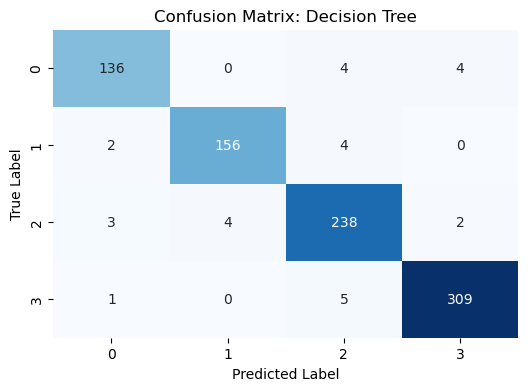

In [65]:
# Evaluate and print metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

# Confusion Matrix
print("Confusion Matrix:")
cm_dt = confusion_matrix(y_test, y_pred_dt)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Decision Tree')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

3. Random Forest Classifier

In [66]:
# Initialize the model
rand_forest = RandomForestClassifier(random_state=42)
# Train the model
rand_forest.fit(X_train, y_train)
# Make predictions
y_pred_rf = rand_forest.predict(X_test)

Accuracy: 0.9873

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       144
           1       1.00      0.99      1.00       162
           2       0.99      0.98      0.99       247
           3       0.99      0.99      0.99       315

    accuracy                           0.99       868
   macro avg       0.99      0.99      0.99       868
weighted avg       0.99      0.99      0.99       868

Confusion Matrix:


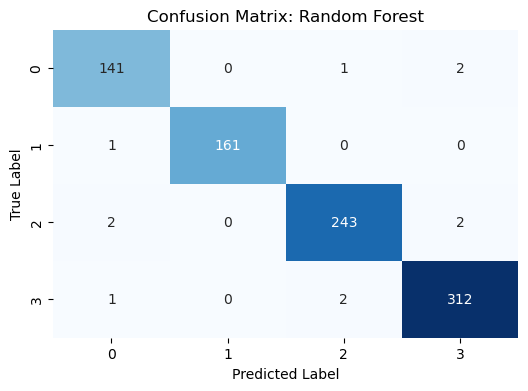

In [67]:
# Evaluate and print metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
print("Confusion Matrix:")
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix: Random Forest')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Selecting best model by comparing by using K-Fold Cross Validation

In [68]:
# create a variable consisting of all models
models = {
    "Logistic Regression": log_reg,
    "Decision Tree": dec_tree,
    "Random Forest": rand_forest
}

In [69]:
# --- Perform 10-Fold Cross-Validation ---
# Set up the cross-validation strategy
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# --- Store Results ---
results = []
names = []

for name, model in models.items():
    print(f"--- {name} ---")
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy')
    results.append(cv_scores)
    names.append(name)
    
    # Print the results
    print(f"Scores for each fold: {np.round(cv_scores, 4)}")
    print(f"Mean Accuracy: {cv_scores.mean():.4f}")
    print(f"Standard Deviation: {cv_scores.std():.4f}\n")


--- Logistic Regression ---
Scores for each fold: [0.9355 0.9447 0.9332 0.9263 0.9401 0.9147 0.9424 0.9447 0.947  0.9238]
Mean Accuracy: 0.9352
Standard Deviation: 0.0101

--- Decision Tree ---
Scores for each fold: [0.9562 0.9654 0.9516 0.9562 0.9585 0.9516 0.9401 0.9631 0.97   0.963 ]
Mean Accuracy: 0.9576
Standard Deviation: 0.0081

--- Random Forest ---
Scores for each fold: [0.9862 0.9839 0.9654 0.9793 0.9631 0.977  0.9816 0.9677 0.9747 0.9792]
Mean Accuracy: 0.9758
Standard Deviation: 0.0075



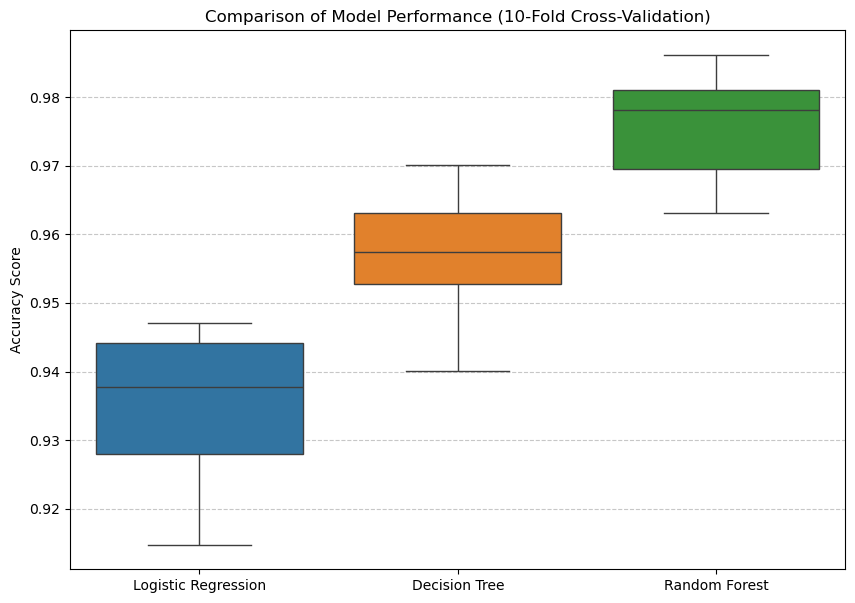

In [70]:
# --- Create the Box Plot ---
plt.figure(figsize=(10, 7))
plt.title('Comparison of Model Performance (10-Fold Cross-Validation)')
sns.boxplot(data=results)
plt.xticks(ticks=[0, 1, 2], labels=names) # Set model names on x-axis
plt.ylabel('Accuracy Score')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()